# <font color=blue>**Exploratory Data Analysis for Click Through Rate (CTR)**</font>

In this notebook, we will try to get some useful insights about data https://www.kaggle.com/c/avazu-ctr-prediction.

## Objectives
    - How CTR is distributed for different days?
    - Are there any Outlier in the dataset? If so identify them.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

***
## Prepocessing

In this section, we will do some preprocesing of data and get some useful insight

In [2]:
df = pd.read_csv(filepath_or_buffer='train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 7.2+ GB


***
There are **40428966** enteries in our dataset.
***

Now we will look how are full dateset look like.

In [4]:
df.head(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [5]:
# check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Total number of duplicate rows are {duplicate_rows}")

Total number of duplicate rows are 0


In [6]:
# extrating the requied fields/attribute/columns
use_cols = ['hour', 'click']
df = df[use_cols]

In [7]:
import preprocessing
# converting the timestampe to the utc format
df = preprocessing.convert_format_to_utc_and_add_to_dataframe(df, date_col='hour', date_format = "%y%m%d%H")
df['target_labels'] = df['click'].map({1:'clicked', 0:"not_clicked"})
df.sample(5)

,hour,click,hour_utc,target_labels
37654348,14103008,0,2014-10-30 08:00:00,not_clicked
20892141,14102606,1,2014-10-26 06:00:00,clicked
29639699,14102812,0,2014-10-28 12:00:00,not_clicked
25344603,14102711,1,2014-10-27 11:00:00,clicked
18575513,14102514,0,2014-10-25 14:00:00,not_clicked


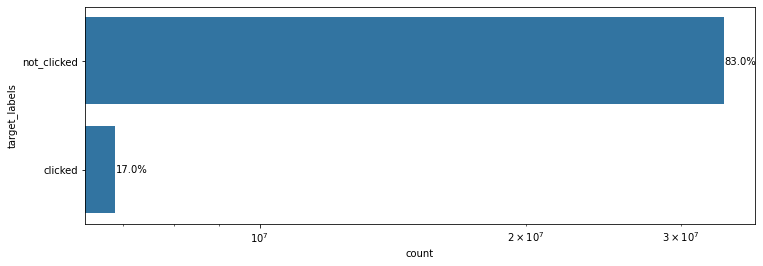

In [8]:
base_color = sns.color_palette()[0]
label_count =df['target_labels'].value_counts()
label_order = label_count.index
plt.figure(figsize=(12, 4))
sns.countplot(data=df, y='target_labels', color= base_color, order = label_order)
plt.xscale('log')
for i in range(label_count.shape[0]):
    count = label_count[i]
    percentage_str = f"{np.around(100*count/df.shape[0])}%"
    plt.text(count+1, i, percentage_str, va="center")

It can be seen that **83%** of total impression the adds are not clicked, and only **17%** of impression, they are clicked. Therefore, it falls in the category of **imbalanced** dataset.

***
## Click Through Rate (CTR)

Now we will look calculate CTR and see how it is distributed.

In [9]:
def calculate_CTR_per_hour_and_add_to_dataframe(
    data: pd.DataFrame, date_col: str
) -> pd.DataFrame:
    """
    This function will calculate the CTR per hour and will it as dataframe.
    :param date_col:
    :param data: Dataframe
    :return: dataframe with ctr_per_hour
    """
    data_aggregated = pd.DataFrame()
    total_clicks_per_hour = data.groupby(f"{date_col}_utc")["click"].sum()
    # total impression are how many time ads are shown i.e. "sum of clicked and not-clicked adds"
    total_impressions_per_hour = data.groupby(f"{date_col}_utc")["click"].count()
    data_aggregated["ctr_per_hour"] = total_clicks_per_hour / total_impressions_per_hour

    return data_aggregated

In [10]:
df_ctr = calculate_CTR_per_hour_and_add_to_dataframe(data= df, date_col='hour')

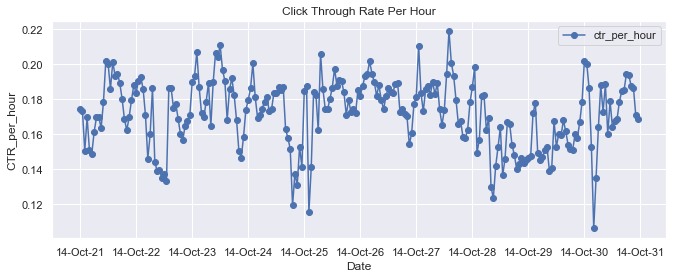

In [11]:
import plotting
plotting.plot_CTR(df_ctr)

***
### Observations
   - If we focus on each day then it can be seen that there is **some** pattern on each day.
   - It looks like there are some outlier, but we will investigate that in the next section.
 ***
 
 Now we will investigate **patterns** further e.g., how clicks are distributed over a single day.

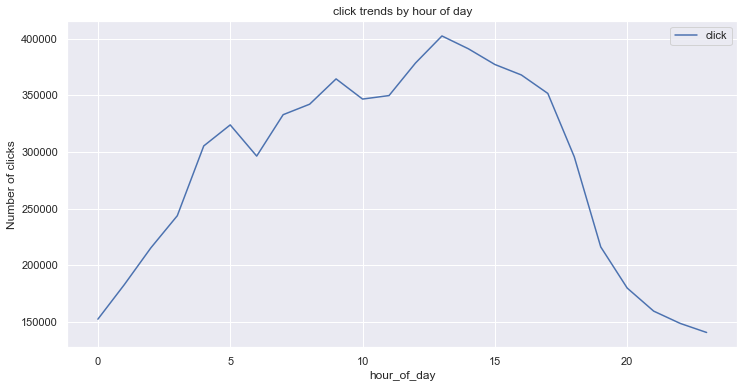

In [12]:
df_clicks= df.reset_index(level=0)
df_clicks['hour_of_day'] = df_clicks.hour_utc.apply(lambda x: x.hour)
df_clicks.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

It can be seen that mostly the clicks are around noon i.e., **12pm**, and are least around the midnight i.e. **12am**. It is look like gaussain curve.

***
## Outlier Detection

total number of outlier for window size 6 are 16
total number of outlier for window size 8 are 20
total number of outlier for window size 10 are 24


<Figure size 792x288 with 0 Axes>

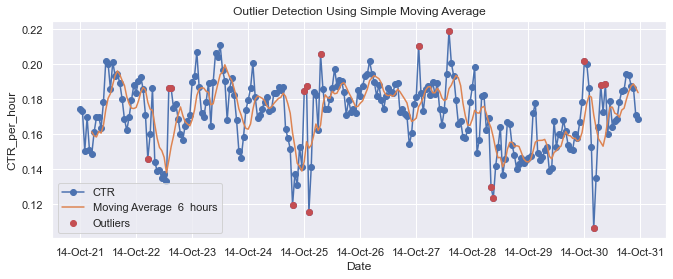

<Figure size 792x288 with 0 Axes>

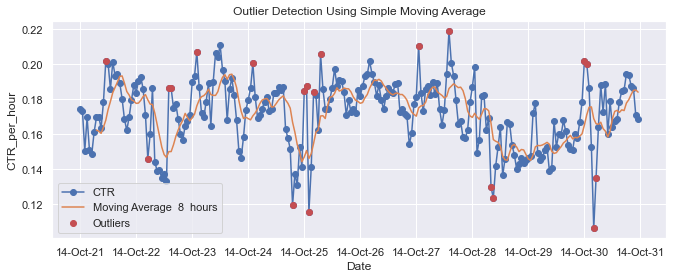

<Figure size 792x288 with 0 Axes>

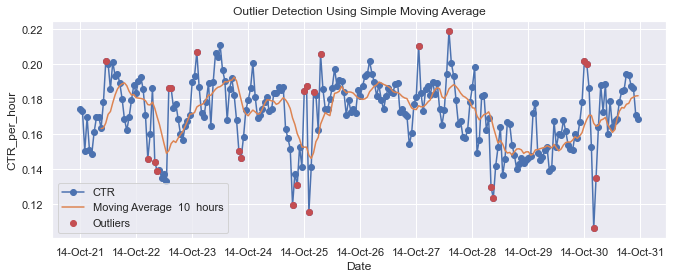

In [13]:
import outlier_detection
window_size = [6, 8, 10]
for i in window_size:
    plt.figure()
    df_outlier = outlier_detection.moving_average(df_ctr, i)
    outliers = df_outlier.outlier_values.value_counts().sum()
    print(f"total number of outlier for window size {i} are {outliers}")
    plotting.plot_outliers(df_outlier, i);

## Findings
    1. It can be seen that the number of outliers increases with the increase of window size. 

We can also use **Z Score** as well to detect outliers.

We also how the CTR is distributed day by day. It may give us some useful insights as well.